# Bibliotecas

In [1]:
# Tratamiento de datos
import pandas as pd
import numpy as np

# Gráficos
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt

# Modelos
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.preprocessing import RobustScaler, OrdinalEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif, SelectKBest
from sklearn import metrics
from sklearn.metrics import classification_report, balanced_accuracy_score, ConfusionMatrixDisplay, confusion_matrix

# XGBoost
from xgboost import XGBClassifier, plot_importance
# Logistic
from sklearn.linear_model import LogisticRegression

# Preprocesado
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer

# Ajuste de hiperparámetros 
from optuna.integration import OptunaSearchCV
from optuna.distributions import IntDistribution, FloatDistribution, CategoricalDistribution
from optuna.visualization.matplotlib import plot_contour, plot_param_importances, plot_intermediate_values
#from optuna.logging import set_verbosity, WARNING
#set_verbosity(WARNING)
# Configuración warnings
# ==============================================================================
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore')



# Guardado / carga del modelo
import pickle

# Semilla
import random
random_seed = 36
np.random.seed(random_seed)
random.seed(random_seed)

/Users/josedavidricodias/Desktop/Universidad/4º/Segundo semestre/Aprendizaje Automático/Grupo36-Practica2/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Función auxiliar para el ajuste de hiperparámetros

In [2]:
def evaluate(model, X, y, cv=5, fit_params=None, tune=False, n_trials=500, metric="accuracy", jobs=1):
    """
     Evalúa cualquier pipeline por validación cruzada.
     Tiene la capacidad de hace una estimación de hiperparámetros con algoritmos heurísticos.
     Tiempo máximo de ejecución 15 minutos en caso de ajuste
    """
    np.random.seed(random_seed)
    random.seed(random_seed)
    
    if not tune:
        cv_results = cross_validate(
            model,
            X,
            y,
            cv=cv,
            scoring=metric,
            fit_params=fit_params,
            return_train_score=True,
            return_estimator=True,
            verbose=0,
            n_jobs=jobs
        )
        return cv_results
    else:
        optuna_search = OptunaSearchCV(estimator=model, 
                                        param_distributions=fit_params, 
                                        cv=cv,
                                        n_trials=n_trials,
                                        timeout=3600,
                                        scoring=metric,
                                        random_state=random_seed,
                                        verbose=0,
                                        n_jobs=jobs)
        optuna_search.fit(X, y)

        return optuna_search

# EDA

Tenemos 4410 instancias, con atributos numéricos y categóricos

In [3]:
disp_df = pd.read_pickle("attrition_available_36.pkl")
disp_df

,hrs,absences,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Age,Attrition,BusinessTravel,...,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
1,NaN,13,2,4.0,3.0,2.0,4.0,31.0,Yes,Travel_Frequently,...,0.0,Y,23.0,8.0,NaN,NaN,3.0,5.0,1.0,NaN
6,6.450877,17,3,NaN,1.0,3.0,1.0,NaN,Yes,Travel_Rarely,...,2.0,Y,NaN,8.0,1.0,5.0,2.0,0.0,0.0,0.0
13,8.871421,14,2,3.0,1.0,2.0,2.0,47.0,Yes,Non-Travel,...,1.0,Y,11.0,NaN,2.0,10.0,NaN,10.0,9.0,9.0
28,10.713066,6,2,NaN,4.0,3.0,1.0,44.0,Yes,Travel_Frequently,...,3.0,NaN,14.0,8.0,1.0,19.0,2.0,1.0,NaN,0.0
30,9.662808,11,2,3.0,NaN,2.0,3.0,NaN,Yes,Travel_Rarely,...,NaN,NaN,11.0,8.0,0.0,NaN,5.0,3.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,8.316921,6,3,3.0,NaN,1.0,3.0,42.0,No,Travel_Rarely,...,3.0,Y,17.0,8.0,1.0,10.0,5.0,3.0,0.0,2.0
4406,5.897197,8,2,3.0,NaN,4.0,3.0,29.0,No,NaN,...,NaN,Y,15.0,8.0,NaN,10.0,2.0,3.0,0.0,2.0
4407,NaN,18,3,NaN,1.0,3.0,3.0,25.0,No,Travel_Rarely,...,NaN,Y,20.0,8.0,0.0,5.0,NaN,4.0,1.0,2.0
4408,9.187612,8,2,3.0,4.0,1.0,3.0,42.0,No,Travel_Rarely,...,0.0,Y,14.0,8.0,1.0,10.0,NaN,9.0,7.0,8.0


Los tipos de datos son numéricos y categóricos

In [4]:
disp_df.dtypes

hrs                        float64
absences                     int64
JobInvolvement               int64
PerformanceRating          float64
EnvironmentSatisfaction    float64
JobSatisfaction            float64
WorkLifeBalance            float64
Age                        float64
Attrition                   object
BusinessTravel              object
Department                  object
DistanceFromHome           float64
Education                  float64
EducationField              object
EmployeeCount              float64
EmployeeID                 float64
Gender                      object
JobLevel                   float64
JobRole                     object
MaritalStatus               object
MonthlyIncome              float64
NumCompaniesWorked         float64
Over18                      object
PercentSalaryHike          float64
StandardHours              float64
StockOptionLevel           float64
TotalWorkingYears          float64
TrainingTimesLastYear      float64
YearsAtCompany      

Columnas categóricas y numéricas

In [5]:
cat_cols = disp_df.select_dtypes(include="object").columns
num_cols = disp_df.select_dtypes(exclude="object").columns
print("Los atributos categóricos son: ", [value for value in cat_cols])
print("Los atributos numéricos son: ", [value for value in num_cols])

Los atributos categóricos son:  ['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18']
Los atributos numéricos son:  ['hrs', 'absences', 'JobInvolvement', 'PerformanceRating', 'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'Age', 'DistanceFromHome', 'Education', 'EmployeeCount', 'EmployeeID', 'JobLevel', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager']


Valores de los atributos categóricos

In [6]:
for col in cat_cols:
    print("Atributo: ", col, "\t\t", pd.unique(disp_df[col]))

Atributo:  Attrition 		 ['Yes' 'No']
Atributo:  BusinessTravel 		 ['Travel_Frequently' 'Travel_Rarely' 'Non-Travel' nan]
Atributo:  Department 		 ['Research & Development' nan 'Human Resources' 'Sales']
Atributo:  EducationField 		 ['Life Sciences' 'Medical' nan 'Human Resources' 'Marketing'
 'Technical Degree' 'Other']
Atributo:  Gender 		 ['Female' 'Male' nan]
Atributo:  JobRole 		 ['Research Scientist' nan 'Manager' 'Sales Executive'
 'Laboratory Technician' 'Manufacturing Director'
 'Healthcare Representative' 'Sales Representative' 'Research Director'
 'Human Resources']
Atributo:  MaritalStatus 		 ['Single' nan 'Divorced' 'Married']
Atributo:  Over18 		 ['Y' nan]


Comentamos que hay variables que no tiene sentido incluir:
- Over18: teniendo la edad no es necesario. Además suponemos que todos los empleados tienen más de 18 años
- EmployeeID: no es relevante para la clasificación. No aporta información

In [7]:
disp_df =  disp_df.drop(columns=['Over18', 'EmployeeID'])

Comprobamos qué columnas son constantes o cuasi-constantes

In [8]:

df_new = disp_df.select_dtypes(exclude='object')
print(df_new.columns)
cleaner = VarianceThreshold()
cleaner.fit_transform(df_new)

for attribute in disp_df.select_dtypes(exclude='object').columns:
    if attribute not in df_new.columns[cleaner.get_support(indices=True)]:
        disp_df.drop(columns=[attribute])

disp_df

Index(['hrs', 'absences', 'JobInvolvement', 'PerformanceRating',
       'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'Age',
       'DistanceFromHome', 'Education', 'EmployeeCount', 'JobLevel',
       'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike',
       'StandardHours', 'StockOptionLevel', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')


,hrs,absences,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Age,Attrition,BusinessTravel,...,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
1,NaN,13,2,4.0,3.0,2.0,4.0,31.0,Yes,Travel_Frequently,...,NaN,0.0,23.0,8.0,NaN,NaN,3.0,5.0,1.0,NaN
6,6.450877,17,3,NaN,1.0,3.0,1.0,NaN,Yes,Travel_Rarely,...,58130.0,2.0,NaN,8.0,1.0,5.0,2.0,0.0,0.0,0.0
13,8.871421,14,2,3.0,1.0,2.0,2.0,47.0,Yes,Non-Travel,...,57620.0,1.0,11.0,NaN,2.0,10.0,NaN,10.0,9.0,9.0
28,10.713066,6,2,NaN,4.0,3.0,1.0,44.0,Yes,Travel_Frequently,...,103330.0,3.0,14.0,8.0,1.0,19.0,2.0,1.0,NaN,0.0
30,9.662808,11,2,3.0,NaN,2.0,3.0,NaN,Yes,Travel_Rarely,...,68540.0,NaN,11.0,8.0,0.0,NaN,5.0,3.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,8.316921,6,3,3.0,NaN,1.0,3.0,42.0,No,Travel_Rarely,...,60290.0,3.0,17.0,8.0,1.0,10.0,5.0,3.0,0.0,2.0
4406,5.897197,8,2,3.0,NaN,4.0,3.0,29.0,No,NaN,...,26790.0,NaN,15.0,8.0,NaN,10.0,2.0,3.0,0.0,2.0
4407,NaN,18,3,NaN,1.0,3.0,3.0,25.0,No,Travel_Rarely,...,37020.0,NaN,20.0,8.0,0.0,5.0,NaN,4.0,1.0,2.0
4408,9.187612,8,2,3.0,4.0,1.0,3.0,42.0,No,Travel_Rarely,...,23980.0,0.0,14.0,8.0,1.0,10.0,NaN,9.0,7.0,8.0


## Estudio de nulos

Proporción de nulos

Solo 2 atributos no tienen nulos

In [9]:
null_proportion = pd.DataFrame({'null proportion': disp_df.isnull().sum() / len(disp_df) * 100})
null_proportion

,null proportion
hrs,19.727891
absences,0.000000
JobInvolvement,0.000000
PerformanceRating,18.594104
EnvironmentSatisfaction,20.702948
JobSatisfaction,0.453515
WorkLifeBalance,18.458050
Age,16.167800
Attrition,0.000000
BusinessTravel,17.369615


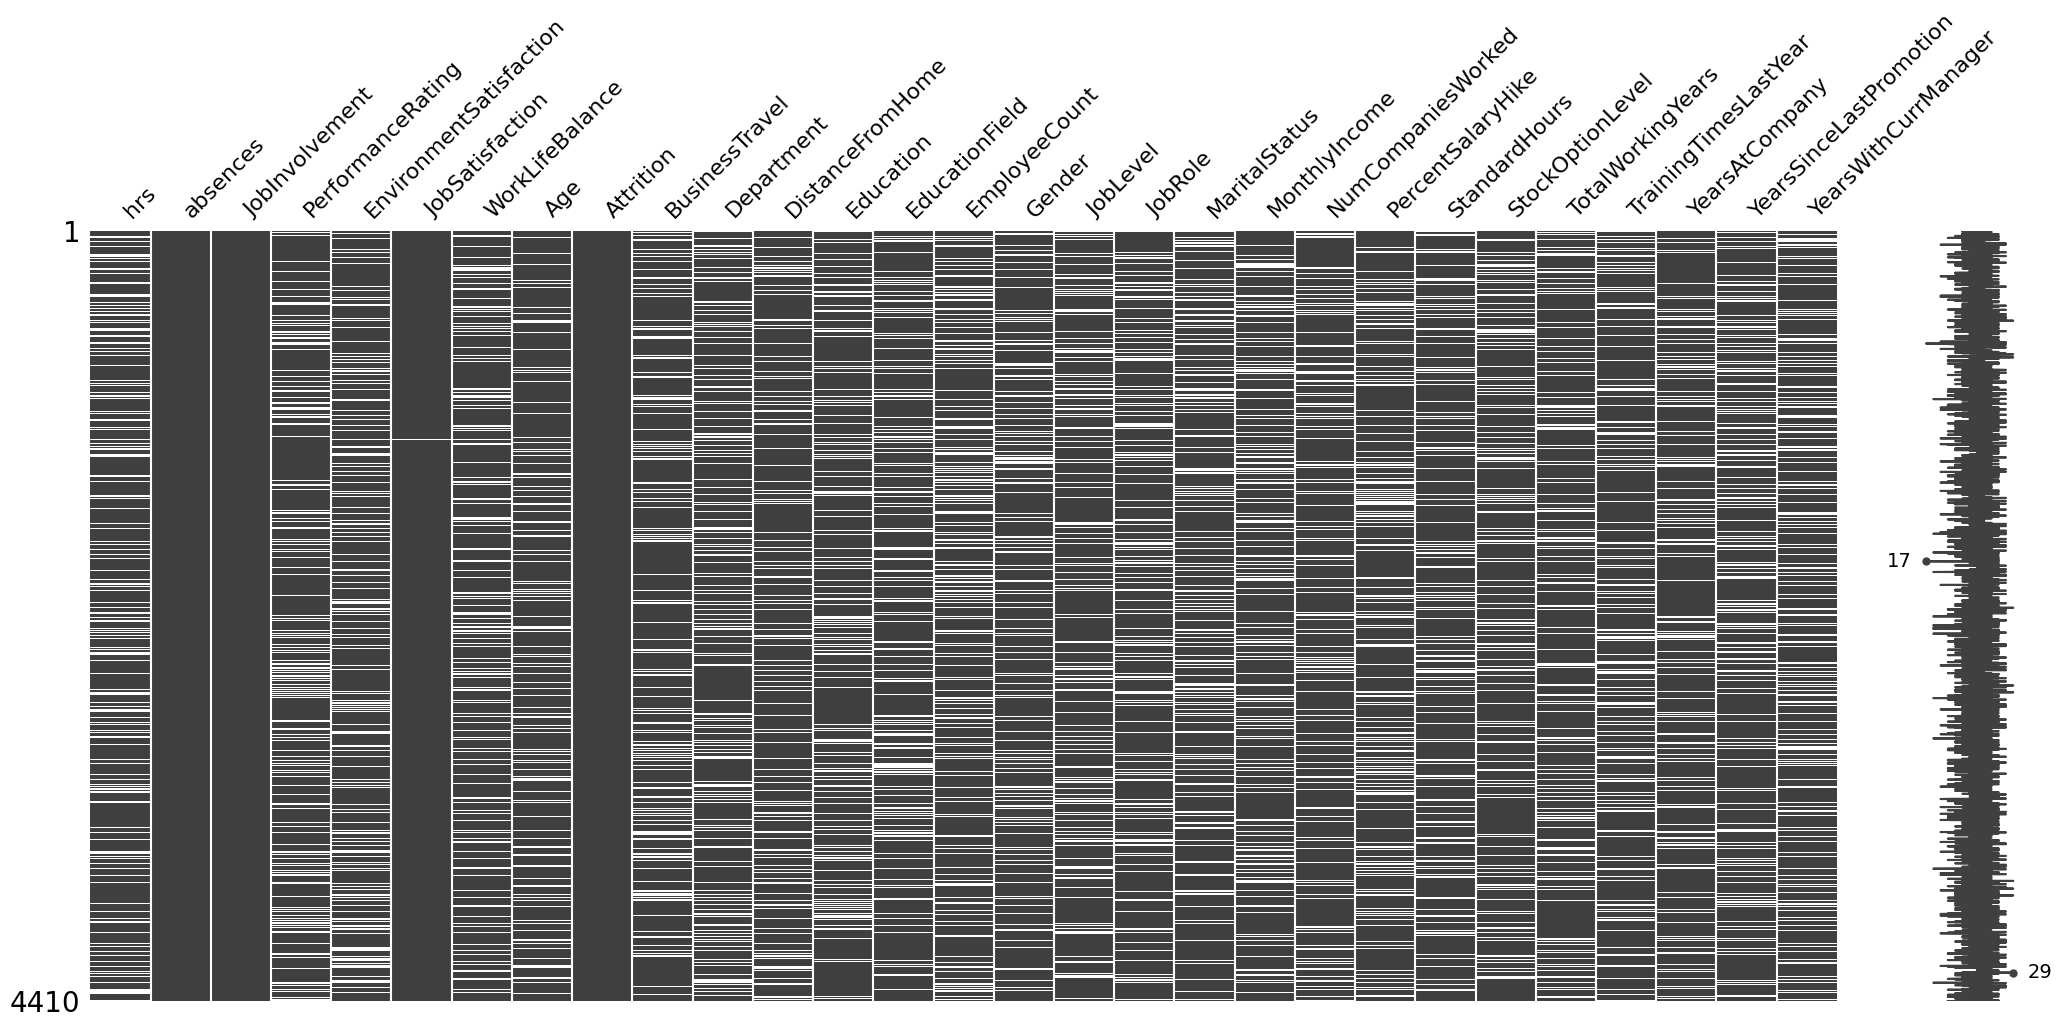

In [10]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'

msno.matrix(disp_df)
plt.show()

## Comprobar nivel de balanceo

In [11]:
print(disp_df['Attrition'].value_counts())

Attrition
No     3699
Yes     711
Name: count, dtype: int64


El modelo está algo desbalanceado, la cantidad de empleados que se fueron de la compañía es inferior a los que no la sienten.

Se trata por tanto de un problema de clasificación, ya que solo hay 2 posibles valores a predecir.

Al dividir un conjunto de datos desequilibrado en conjuntos de entrenamiento y prueba, es importante asegurarse de que la división sea estratificada, lo que significa que la proporción de clases en ambos conjuntos sea similar a la proporción de clases en el conjunto de datos original. Para hacer esto, se puede utilizar la función train_test_split de scikit-learn junto con el parámetro stratify.

# División de los datos en entrenamiento y test

Los modelos de aprendizaje automático requieren que las variables categóricas se codifiquen como variables numéricas. Para hacer esto, podemos utilizar técnicas como la codificación One-Hot (también conocida como codificación Dummy) o la codificación ordinal. La codificación One-Hot crea una columna binaria para cada categoría, mientras que la codificación ordinal asigna un número a cada categoría según su orden. Scikit-learn proporciona varias herramientas para codificar variables categóricas, como OneHotEncoder y OrdinalEncoder.

Para las variables categóticas vamos a crear un pipeline donde:

    - Si hubiese una muestra con valores nulos, le vamos a imputar el valor del más frecuente.
    - Codificaremos con la técnicas One_Hot_Encoder.
    - Aplicaremos sobre ellos un PCA, para extraer características más discriminantes

In [12]:
y_df = pd.DataFrame(disp_df['Attrition'], columns=['Attrition'])
X_df = disp_df.drop(columns='Attrition')

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, stratify=y_df, test_size=0.33)

# Modelos

## Modelos sin filtrado

### Logistic Regression

Creamos un pipeline para imputar los nulos y transformar los categóricos

In [14]:
cat_transformer = Pipeline(steps=[
    ('ordincalencoder', OrdinalEncoder()),
    ('imputer', IterativeImputer(random_state=random_seed, max_iter=25)),
    ('standardscaler', StandardScaler())
])
cat_transformer

Pipeline(steps=[('ordincalencoder', OrdinalEncoder()),
                ('imputer', IterativeImputer(max_iter=25, random_state=36)),
                ('standardscaler', StandardScaler())])

In [15]:
num_transformer = Pipeline(steps=[
    ('imputer', KNNImputer()),
    ('scaler', RobustScaler())
])
num_transformer

Pipeline(steps=[('imputer', KNNImputer()), ('scaler', RobustScaler())])

Pipeline para el preprocesado de atributos

In [16]:
preprocessor = ColumnTransformer(transformers=[
        ('num', num_transformer, selector(dtype_exclude=[object])),
        ('cat', cat_transformer, selector(dtype_include=[object]))
])

preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', KNNImputer()),
                                                 ('scaler', RobustScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x17bcef220>),
                                ('cat',
                                 Pipeline(steps=[('ordincalencoder',
                                                  OrdinalEncoder()),
                                                 ('imputer',
                                                  IterativeImputer(max_iter=25,
                                                                   random_state=36)),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x17bceefb0>)])

In [17]:
pipe_lr_default = Pipeline(steps=[
    ('process', preprocessor),
    ('lr', LogisticRegression(penalty=None, class_weight='balanced'))
])

pipe_lr_default

Pipeline(steps=[('process',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x17bcef220>),
                                                 ('cat',
                                                  Pipeline(steps=[('ordincalencoder',
                                                                   OrdinalEncoder()),
                                                                  ('imputer',
                                                                   IterativeImputer(max_iter=25,
                                                                                    random_state=36)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x17bceefb0>)])),
                ('lr',
                 LogisticRegression(class_weight='balanced', penalty=None))])

Ahora evaluamos por balanced accuracy, f1 y precision

In [18]:
balanced_score = cross_val_score(pipe_lr_default, X_train, y_train, scoring='balanced_accuracy')
f1_score = cross_val_score(pipe_lr_default, X_train, y_train, scoring='f1_weighted')
precision_score = cross_val_score(pipe_lr_default, X_train, y_train, scoring='precision_weighted')
recall_score = cross_val_score(pipe_lr_default, X_train, y_train, scoring='recall_weighted')

In [19]:
print(f"Average balance accuracy is: {balanced_score.mean():.2f} +- {balanced_score.std():.2f}")
print(f"Average f1 score is: {f1_score.mean():.2f} +- {f1_score.std():.2f}")
print(f"Average precision is: {precision_score.mean():.2f} +- {precision_score.std():.2f}")
print(f"Average recall is: {recall_score.mean():.2f} +- {recall_score.std():.2f}")

Average balance accuracy is: 0.68 +- 0.03
Average f1 score is: 0.73 +- 0.02
Average precision is: 0.82 +- 0.01
Average recall is: 0.69 +- 0.02


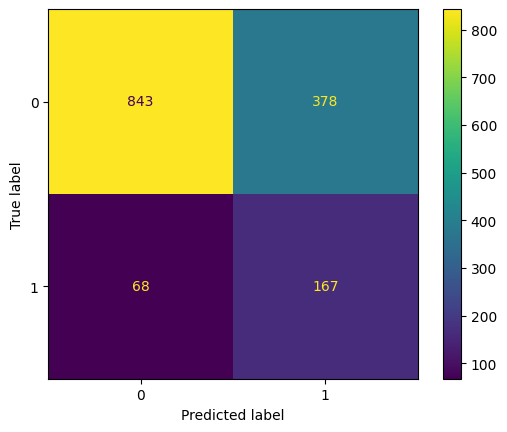

In [20]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

pipe_lr_default.fit(X_train, y_train)

y_pred = pipe_lr_default.predict(X_test)

y_pred = le.fit_transform(y_pred)


cm = confusion_matrix(y_test, y_pred, labels=pipe_lr_default.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe_lr_default.classes_)
disp.plot()
plt.show()

### XGBoost

XGBoost no necesita ni tratamiento de nulos ni codificación de variables categóricas. Aún así encontramos útil hacer el mismo preprocesado que con Logistic Regression para que los datos sean comparables

In [21]:
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier())
])

In [22]:
xgboost_dist={
    'classifier__learning_rate': FloatDistribution(0, 1),
    'classifier__gamma': FloatDistribution(10e-3, 10e10, log=True),
    'classifier__max_depth': IntDistribution(1, 15),
    'classifier__min_child_weight': IntDistribution(0, 10),
    'classifier__subsample': FloatDistribution(0, 1),
    'classifier__lambda': FloatDistribution(10e-3, 10e3, log=True),
    'classifier__alpha': FloatDistribution(10e-3, 10e3, log=True),
    'classifier__colsample_bytree': FloatDistribution(0, 1),
    'classifier__scale_pos_weight': FloatDistribution(10e-3, 10e1, log=True)
}

#param_dist = {**num_transformer_dist, **cat_transformer_dist, **xgboost_dist}
param_dist = {**xgboost_dist}

In [23]:
xgboost_clf = None
try:
    study = open("optuna_xgboost_study_without_filter.pkl", 'rb')
    xgboost_clf = pickle.load(study)
except FileNotFoundError:
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    xgboost_clf = evaluate(clf, X_train, y_train, cv=5, fit_params=param_dist, tune=True, n_trials=100, metric="precision", jobs=-1)
    
    pickle.dump(xgboost_clf.best_estimator_, open("optuna_xgboost_study_without_filter.pkl", "wb"))

[I 2023-05-11 22:01:01,747] A new study created in memory with name: no-name-01018162-f1e6-429f-8735-ae7f0052bcb0
[I 2023-05-11 22:01:16,411] Trial 5 finished with value: 0.0 and parameters: {'classifier__learning_rate': 0.5396455236846812, 'classifier__gamma': 150504034.24660212, 'classifier__max_depth': 5, 'classifier__min_child_weight': 5, 'classifier__subsample': 0.1833788573977938, 'classifier__lambda': 2.0254549059697697, 'classifier__alpha': 5.044388206599664, 'classifier__colsample_bytree': 0.2896992922327042, 'classifier__scale_pos_weight': 0.04220567129954507}. Best is trial 5 with value: 0.0.
[I 2023-05-11 22:01:16,423] Trial 3 finished with value: 0.0 and parameters: {'classifier__learning_rate': 0.11800655326076637, 'classifier__gamma': 0.1829452002023224, 'classifier__max_depth': 9, 'classifier__min_child_weight': 3, 'classifier__subsample': 0.20948664030819075, 'classifier__lambda': 24.733748539031872, 'classifier__alpha': 430.832490314375, 'classifier__colsample_bytree'

In [24]:
xgboost_clf.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x17eb012a0>),
                                                 ('cat',
                                                  Pipeline(steps=[('ordincalencoder',
                                                                   OrdinalEncoder()),
                                                                  ('imputer',
                                                                   IterativeImputer(max_iter=25,
                                                                                    random_state=36)),
                                                                  ('standardsca...
                               gpu_id=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               lambda=0.015981583780105522,
                               learning_rate=0.6231602588029579, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=8,
                               max_leaves=None, min_child_weight=1, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None, ...))])

Hace las validación

In [25]:
print("Balanced accuracy: ", cross_val_score(xgboost_clf.best_estimator_, X_train, y_train, cv=5, scoring="balanced_accuracy").mean())
print("f1 score: ", cross_val_score(xgboost_clf.best_estimator_, X_train, y_train, cv=5, scoring="f1_weighted").mean())
print("Precision: ", cross_val_score(xgboost_clf.best_estimator_, X_train, y_train, cv=5, scoring="precision_weighted").mean())
print("Recall: ", cross_val_score(xgboost_clf.best_estimator_, X_train, y_train, cv=5, scoring="recall_weighted").mean())

Balanced accuracy:  0.7115984762737734
f1 score:  0.878983761061613
Precision:  0.8852548699982352
Recall:  0.8920118156528721


In [26]:
y_pred = xgboost_clf.best_estimator_.predict(X_test)
le = LabelEncoder()
y_pred = le.fit_transform(y_pred)

Informe de clasificación

In [27]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94      1221
           1       0.80      0.51      0.62       235

    accuracy                           0.90      1456
   macro avg       0.85      0.74      0.78      1456
weighted avg       0.89      0.90      0.89      1456



De forma gráfica

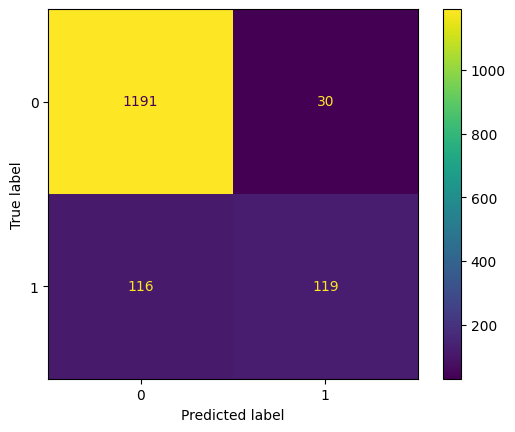

In [28]:
cm = confusion_matrix(y_test, y_pred, labels=xgboost_clf.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgboost_clf.classes_)
disp.plot()
plt.show()

Obtenemos las curva ROC y el área bajo la curva (AUC) y comparamos el modelo base (LogReg) con XGBoost ajustado

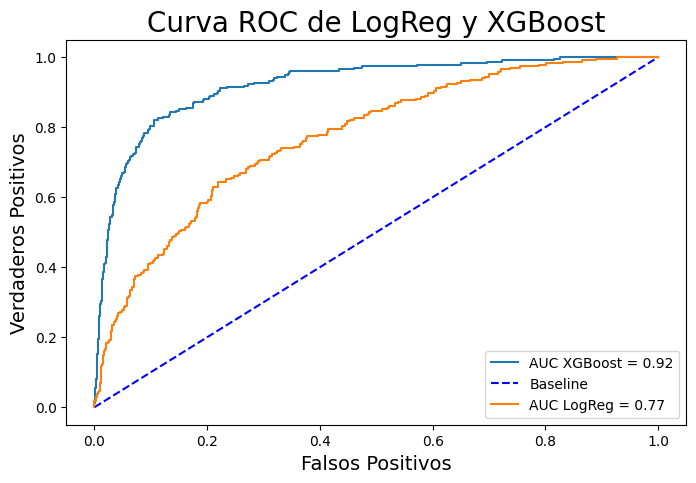

In [29]:
probs = xgboost_clf.predict_proba(X_test)[:, 1]

auc = metrics.roc_auc_score(y_test, probs)
fpr, tpr, thresholds = metrics.roc_curve(y_test, probs)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f'AUC XGBoost = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Baseline')

pipe_lr_default.fit(X_train, y_train)
probs = pipe_lr_default.predict_proba(X_test)[:, 1]
auc = metrics.roc_auc_score(y_test, probs)
fpr, tpr, thresholds = metrics.roc_curve(y_test, probs)

plt.plot(fpr, tpr, label=f'AUC LogReg = {auc:.2f}')


plt.title('Curva ROC de LogReg y XGBoost', size=20)
plt.xlabel('Falsos Positivos', size=14)
plt.ylabel('Verdaderos Positivos', size=14)
plt.legend()

## Modelos con filtrado

Ahora repetimos el entrenamiento anterior pero con filtrado de atributos

### Logistic Regression

In [30]:
pipe_lr_default = Pipeline(steps=[
    ('process', preprocessor),
    ('filter', SelectKBest()),
    ('lr', LogisticRegression(penalty=None, class_weight='balanced'))
])

pipe_lr_default

Pipeline(steps=[('process',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x17bcef220>),
                                                 ('cat',
                                                  Pipeline(steps=[('ordincalencoder',
                                                                   OrdinalEncoder()),
                                                                  ('imputer',
                                                                   IterativeImputer(max_iter=25,
                                                                                    random_state=36)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x17bceefb0>)])),
                ('filter', SelectKBest()),
                ('lr',
                 LogisticRegression(class_weight='balanced', penalty=None))])

Ahora evaluamos por balanced accuracy, f1 y precision

In [31]:
balanced_score = cross_val_score(pipe_lr_default, X_train, y_train, scoring='balanced_accuracy')
f1_score = cross_val_score(pipe_lr_default, X_train, y_train, scoring='f1_weighted')
precision_score = cross_val_score(pipe_lr_default, X_train, y_train, scoring='precision_weighted')
recall_score = cross_val_score(pipe_lr_default, X_train, y_train, scoring='recall_weighted')

In [32]:
print(f"Average balanced accuracy is: {balanced_score.mean():.2f} +- {balanced_score.std():.2f}")
print(f"Average f1 score is: {f1_score.mean():.2f} +- {f1_score.std():.2f}")
print(f"Average precision is: {precision_score.mean():.2f} +- {precision_score.std():.2f}")
print(f"Average recall is: {recall_score.mean():.2f} +- {recall_score.std():.2f}")

Average balanced accuracy is: 0.69 +- 0.03
Average f1 score is: 0.73 +- 0.02
Average precision is: 0.82 +- 0.01
Average recall is: 0.69 +- 0.02


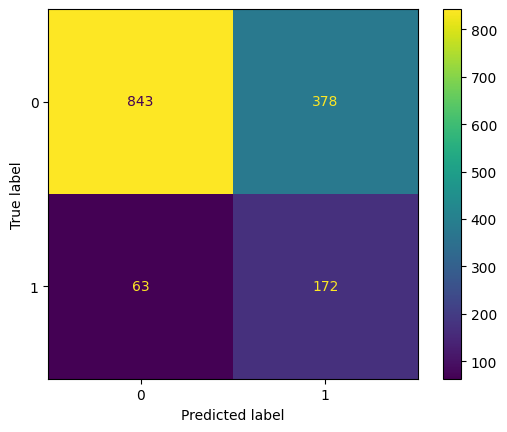

In [33]:

pipe_lr_default.fit(X_train, y_train)

y_pred = pipe_lr_default.predict(X_test)

y_pred = le.fit_transform(y_pred)


cm = confusion_matrix(y_test, y_pred, labels=pipe_lr_default.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe_lr_default.classes_)
disp.plot()
plt.show()

### XGBoost

XGBoost no necesita ni tratamiento de nulos ni codificación de variables categóricas. Aún así encontramos útil hacer el mismo preprocesado que con Logistic Regression para que los datos sean comparables

In [34]:
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('filter', SelectKBest()),
    ('classifier', XGBClassifier(seed=36))
])

In [35]:
xgboost_dist = {
    'classifier__learning_rate': FloatDistribution(0, 1),
    'classifier__gamma': FloatDistribution(10e-3, 10e10, log=True),
    'classifier__max_depth': IntDistribution(1, 15),
    'classifier__min_child_weight': IntDistribution(0, 10),
    'classifier__subsample': FloatDistribution(0, 1),
    'classifier__lambda': FloatDistribution(10e-3, 10e3, log=True),
    'classifier__alpha': FloatDistribution(10e-3, 10e3, log=True),
    'classifier__colsample_bytree': FloatDistribution(0, 1),
    'classifier__scale_pos_weight': FloatDistribution(10e-3, 10e1, log=True)
}
filter_dist = {
    'filter__k': IntDistribution(10, len(disp_df.columns)-1),
}
#param_dist = {**num_transformer_dist, **cat_transformer_dist, **xgboost_dist}
param_dist = {**filter_dist, **xgboost_dist}

In [36]:
xgboost_clf = None
try:
    study = open("optuna_xgboost_study_with_filter.pkl", 'rb')
    xgboost_clf = pickle.load(study)
except FileNotFoundError:
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    xgboost_clf = evaluate(clf, X_train, y_train, cv=5, fit_params=param_dist, tune=True, n_trials=100, metric="balanced_accuracy", jobs=-1)
    pickle.dump(xgboost_clf.best_estimator_, open("optuna_xgboost_study_with_filter.pkl", "wb"))

In [41]:
xgboost_clf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x2800e8cd0>),
                                                 ('cat',
                                                  Pipeline(steps=[('ordincalencoder',
                                                                   OrdinalEncoder()),
                                                                  ('imputer',
                                                                   IterativeImputer(max_iter=25,
                                                                                    random_state=36)),
                                                                  ('standardsca...
                               gpu_id=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               lambda=0.015981583780105522,
                               learning_rate=0.6231602588029579, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=8,
                               max_leaves=None, min_child_weight=1, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None, ...))])

Hace las validación

In [43]:
print("Balanced accuracy: ", cross_val_score(xgboost_clf, X_train, y_train, cv=5, scoring="balanced_accuracy").mean())
print("f1 score: ", cross_val_score(xgboost_clf, X_train, y_train, cv=5, scoring="f1_weighted").mean())
print("Precision: ", cross_val_score(xgboost_clf, X_train, y_train, cv=5, scoring="precision_weighted").mean())
print("Recall: ", cross_val_score(xgboost_clf, X_train, y_train, cv=5, scoring="recall_weighted").mean())

Balanced accuracy:  0.7115984762737734
f1 score:  0.878983761061613
Precision:  0.8852548699982352
Recall:  0.8920118156528721


In [45]:
y_pred = xgboost_clf.predict(X_test)
le = LabelEncoder()
y_pred = le.fit_transform(y_pred)

Informe de clasificación

In [46]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94      1221
           1       0.80      0.51      0.62       235

    accuracy                           0.90      1456
   macro avg       0.85      0.74      0.78      1456
weighted avg       0.89      0.90      0.89      1456



De forma gráfica

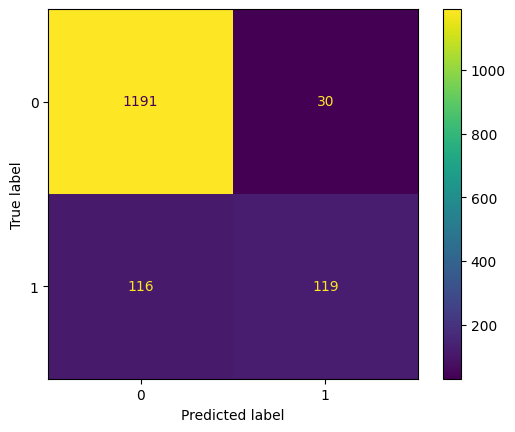

In [47]:
cm = confusion_matrix(y_test, y_pred, labels=xgboost_clf.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgboost_clf.classes_)
disp.plot()
plt.show()

Obtenemos las curva ROC y el área bajo la curva (AUC) y comparamos el modelo base (LogReg) con XGBoost ajustado

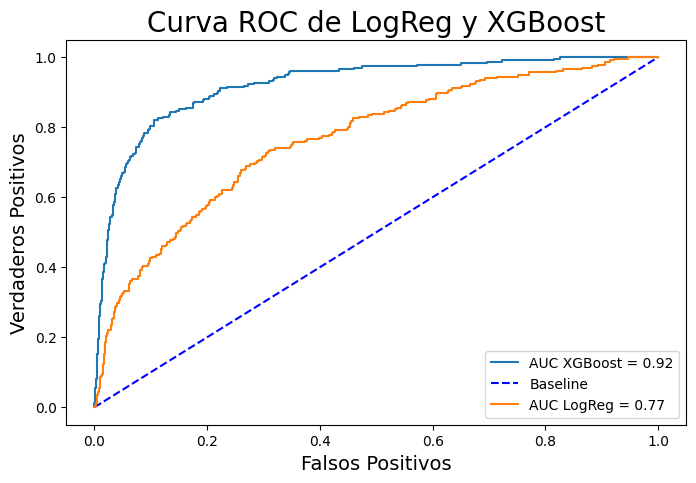

In [48]:
probs = xgboost_clf.predict_proba(X_test)[:, 1]

auc = metrics.roc_auc_score(y_test, probs)
fpr, tpr, thresholds = metrics.roc_curve(y_test, probs)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f'AUC XGBoost = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Baseline')

pipe_lr_default.fit(X_train, y_train)
probs = pipe_lr_default.predict_proba(X_test)[:, 1]
auc = metrics.roc_auc_score(y_test, probs)
fpr, tpr, thresholds = metrics.roc_curve(y_test, probs)

plt.plot(fpr, tpr, label=f'AUC LogReg = {auc:.2f}')


plt.title('Curva ROC de LogReg y XGBoost', size=20)
plt.xlabel('Falsos Positivos', size=14)
plt.ylabel('Verdaderos Positivos', size=14)
plt.legend()

Conclusión: tras el filtrado el AUC del XGBoost ajustado ha mejorado notablemente y el AUC del Logistic Regression no ha cambiado.

Los atributos más importantes son los siguientes:

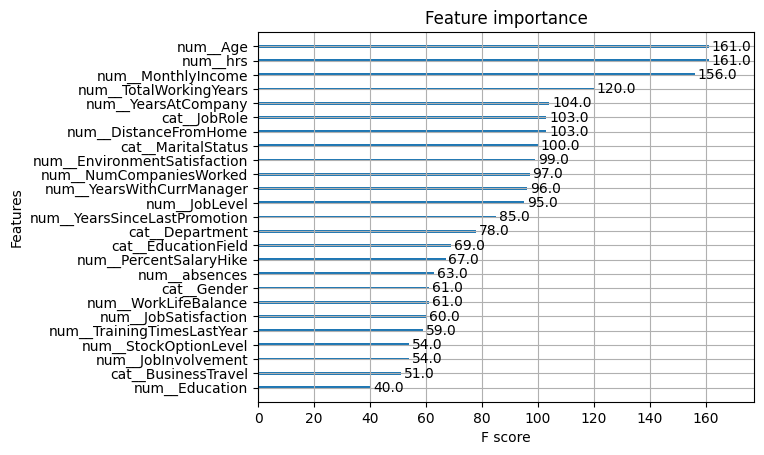

In [51]:
xgboost_clf['classifier'].get_booster().feature_names = list(xgboost_clf[0].get_feature_names_out()) 
plot_importance(xgboost_clf['classifier'], max_num_features=25)
plt.show()

Se entrena y guarda el modelo final (con el filtrado de atributos):

In [53]:
le = LabelEncoder()
y_df = le.fit_transform(y_df)
xgboost_clf.fit(X_df, y_df)

pickle.dump(xgboost_clf, open("modelo_final.pkl", "wb"))